# Determining the Likelihood of Recession with Markov Processes 


This project uses a weekly economic index data from the Saint Luis Federal Reserve. We begin with an investigation of the time series, and create a model for the index. Then, we represent the data as a Markov process, and determine the likelihood of a recession like that seen in the 2020.

More information about the dataset, and the ingredients for the index can be found [here](https://fred.stlouisfed.org/series/WEI)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.arima.model as arima
from statsmodels.graphics.tsaplots import plot_pacf
from fredapi import Fred
from quantecon import MarkovChain
import quantecon as qe
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

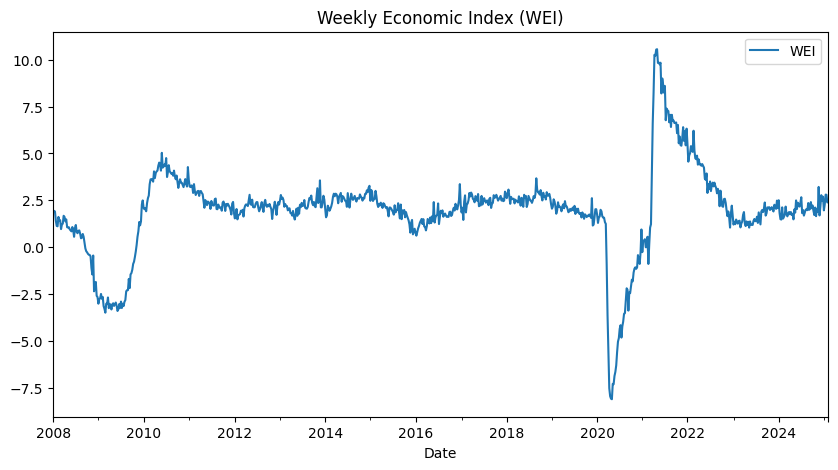

In [6]:
fred = Fred(api_key='6c0ecd6565503b64631fd2b36f71293a')
df = fred.get_series("WEI")
df = df.to_frame(name="WEI")
df.index.name = "Date"

# Plot the WEI data
df.plot(title="Weekly Economic Index (WEI)", figsize=(10,5))
plt.show()


# Augmented Dickey Fuller Test

We use adf to determine if the index is stationary. A stationary index isn't expected to change in value over time. 

In [7]:
series = df['WEI']

# Perform the Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(series)
print("ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

ADF Test Results:
ADF Statistic: -3.6422
p-value: 0.0050
Critical Values:
  1%: -3.4378
  5%: -2.8648
  10%: -2.5685


Our adf p-value is 0.054, meaning we cannot reject the null hypothesis that index is stationary at the five percent level. 

# Partial Autocorrelation

Next, we plot the correlation of the current weekly index of the time series with each of the twenty five preceding indices. This gives us insight into what time values impact the current index. For example, if the current index is only partially correlated with the first lag, than this is a first order process, and so on.  

<Figure size 1000x500 with 0 Axes>

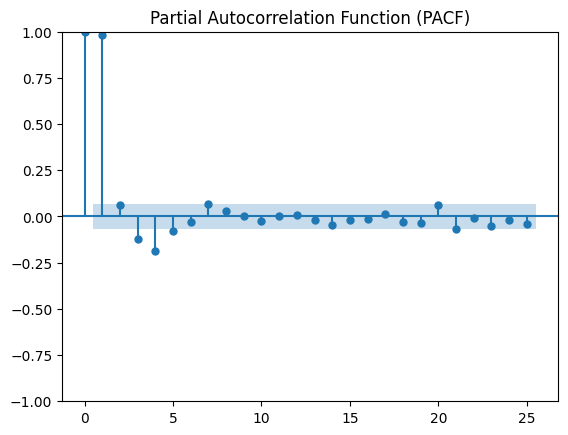

In [8]:
# Plot Partial Autocorrelation Function (PACF) up to 25 lags
plt.figure(figsize=(10, 5))
plot_pacf(series, lags=25, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

We see that this is, indeed, a first order autoregressive process, meaning the current value of the time series is only directly influenced by the value at time t - 1. 

# Estimating the AR1 model

A first order autoregressive model has the form;

$y_t = \beta_0 * y_{t-1} + \epsilon$

Where $\epsilon$ represents random shocks drawn from a normal distribution

Next, we try to extract the coefficient $\beta_0$, which will show how the current index is influenced by the week before.

In [9]:
# Estimate an AR(1) Model
model = ARIMA(series, order=(1, 0, 0))  # AR(1) model
results = model.fit()

# Print the estimated coefficient of the lagged variable
print("\nAR(1) Model Results:")
print(results.summary())

# Extract the coefficient on the one-lagged endogenous variable
ar1_coefficient = results.params[1]  # AR(1) coefficient
print(f"\nEstimated Coefficient on Lagged Variable: {ar1_coefficient:.4f}")

c:\Users\jonat\OneDrive\econometrics\dynamic_stochastic\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\jonat\OneDrive\econometrics\dynamic_stochastic\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
c:\Users\jonat\OneDrive\econometrics\dynamic_stochastic\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)



AR(1) Model Results:
                               SARIMAX Results                                
Dep. Variable:                    WEI   No. Observations:                  893
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -511.368
Date:                Thu, 13 Feb 2025   AIC                           1028.735
Time:                        10:56:18   BIC                           1043.119
Sample:                    01-05-2008   HQIC                          1034.232
                         - 02-08-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9563      0.756      2.587      0.010       0.474       3.439
ar.L1          0.9810      0.005    212.337      0.000       0.972       0.990
sigma2         0.1834      0.0

C:\Users\jonat\AppData\Local\Temp\ipykernel_20700\480352654.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar1_coefficient = results.params[1]  # AR(1) coefficient


The estimate for $\beta_0$ is 0.9810, meaning we would expect each weekly index to be slightly lower than that of the week before.

# The State Space

In order to conduct analysis of the weekly economic index as a Markov Process, we need to represent all possible outcomes in a state space, corresponding to the bins of the following histogram. The probabilities assigned to each state will, of course, correspond to the probability that state in question is observed in the index.

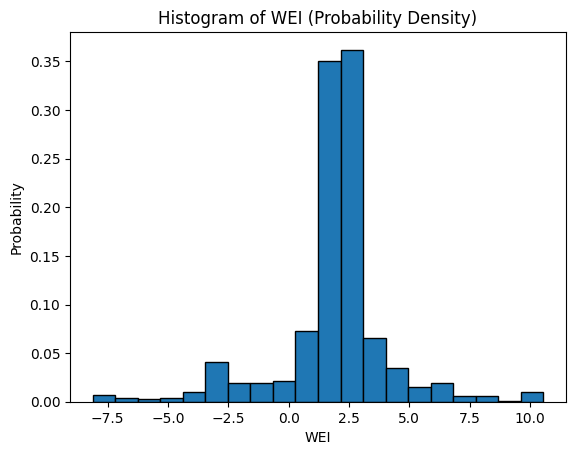

Counts (as probabilities): [0.00719371 0.00359685 0.0023979  0.00359685 0.00959161 0.04076436
 0.01918323 0.01918323 0.02158113 0.07313605 0.35009388 0.36208339
 0.06594234 0.0347696  0.01558637 0.01918323 0.00599476 0.00599476
 0.00119895 0.00959161] 

Bins: [-8.12  -7.186 -6.252 -5.318 -4.384 -3.45  -2.516 -1.582 -0.648  0.286
  1.22   2.154  3.088  4.022  4.956  5.89   6.824  7.758  8.692  9.626
 10.56 ] 



In [10]:
y, bins, patches = plt.hist(df["WEI"].dropna(), bins=20, edgecolor='black', density=True)
plt.title("Histogram of WEI (Probability Density)")
plt.xlabel("WEI")
plt.ylabel("Probability")
plt.show()

print("Counts (as probabilities):", y, "\n")
print("Bins:", bins, "\n")
# print("Patches:", patches, "\n")

In [11]:
def classify(x, bins, states):
    n = len(bins)
    conditions = [(x >= bins[i]) & (x < bins[i+1]) for i in range(n-1)]
    return np.select(conditions, states, default="Unknown")

states = [f"State_{i}" for i in range(len(bins)-1)]
df["State"] = classify(df["WEI"], bins, states)

# group the data by the mean growth rate in each state
state_means = df.groupby("State")["WEI"].mean()

df.head()

,WEI,State
Date,,
2008-01-05,1.94,State_10
2008-01-12,1.93,State_10
2008-01-19,1.90,State_10
2008-01-26,1.41,State_10
2008-02-02,1.13,State_9


# The Markov Matrix

We represent the index with a matrix, where each value corresponding to the probability of entering a state given the current value of the time series. We investigate whether the matrix is aperiodic (will not have natural cycles) or irreducible (You can reach any state from any other state).

We also generate the Ergodic distribution, which shows the proportion of time the weekly economic index will spend in each state, if we extend the time series out to infinity.

In [12]:
P = pd.crosstab(df["State"].shift(1), df["State"], normalize=0).values
mc = MarkovChain(P)
print("The Markov Matrix aperiodic:", mc.is_aperiodic)
print("The Markov Matrix irreducible:", mc.is_irreducible)

The Markov Matrix aperiodic: True
The Markov Matrix irreducible: True


In [13]:
print("Ergodic distribution: \n", mc.stationary_distributions)

Ergodic distribution: 
 [[0.006679   0.0033395  0.32483545 0.34037119 0.06203052 0.032707
  0.01466176 0.01804524 0.00563914 0.00563914 0.00112783 0.00789479
  0.00222633 0.0033395  0.00890533 0.03784844 0.01781127 0.0178103
  0.02003878 0.06792165 0.00112783]]


We use the Markov Matrix to generate the following two year simulation of the index as a markov process;

C:\Users\jonat\AppData\Local\Temp\ipykernel_20700\282244992.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation = mc.simulate(ts_length=52, init=X[-1])


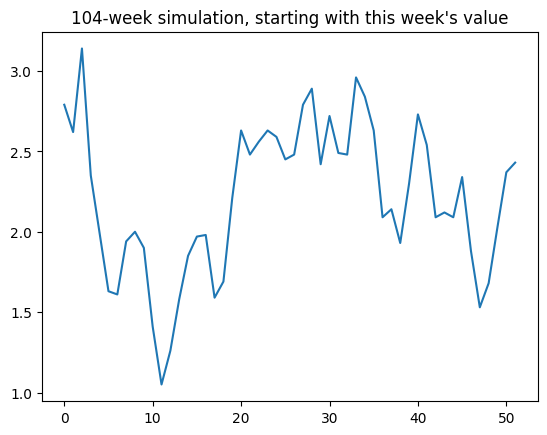

In [14]:
X=df["WEI"][:-2] #something is buggy about the new data's tail on 4 February 2023
mc=qe.markov.estimate.estimate_mc(X)
simulation = mc.simulate(ts_length=52, init=X[-1])
plt.plot(simulation)
plt.title("104-week simulation, starting with this week's value")
plt.show()

In generating 1000 simulations, we find that the chance of another recession on the order of 2020 is just over five percent

In [16]:
covid_pass_probs = []
for _ in range(1000):
    simulated_states = mc.simulate(ts_length=104, init=X[-1])
    covid_pass_probs.append(1 if 0 in simulated_states else 0)
mean_pass_prob_covid = np.mean(covid_pass_probs)
print("Average Probability of passing through a recession state in 2 years (1000 simulations):", mean_pass_prob_covid)

Average Probability of passing through a recession state in 2 years (1000 simulations): 0.037


C:\Users\jonat\AppData\Local\Temp\ipykernel_20700\3705617818.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulated_states = mc.simulate(ts_length=104, init=X[-1])
